In [ ]:
import numpy as np
from matplotlib import pyplot as plt

Fix random seed so that experiments are reproducible.

In [ ]:
seed = 88
np.random.seed(seed)

In [ ]:
d =   int(2e2)
n =   int(1e2)
n_t = int(5e3)

X   = np.random.normal(loc=0.,
                       scale=1.,
                       size=(n,d))
X_t = np.random.normal(loc=0.,
                       scale=1.,
                       size=(n_t,d))
normalize = lambda X : X / np.linalg.norm(X, axis=1)[..., None]
f = lambda X : np.mean(np.sin(X), axis=1)

X   = normalize(X)
X_t = normalize(X_t)

y   = f(X)
y_t = f(X_t)

In [ ]:
mse = lambda y_t, y_pred : np.mean(np.square(y_t - y_pred))

# 6

Given an activation $\phi$, let $\xi := \boldsymbol{x}^\mathsf{T} \tilde{\boldsymbol{x}}$, where $\boldsymbol{x}, \tilde{\boldsymbol{x}} \in \mathcal{S}^{d-1}$,<br>
then the kernel is $\Sigma (\boldsymbol{x}, \tilde{\boldsymbol{x}}) = \check{\phi}(\xi)$,<br>
hence, the predictor is
$$
\hat{\boldsymbol{y}} = \underbrace{\boldsymbol{y} \hat{\mathbf{K}}^{-1}}_\boldsymbol{\alpha} \hat{\mathbf{K}}(\mathbf{X}, \boldsymbol{x})
$$

In [ ]:
def predict(func, X_train=X, y_train=y,
            X_test=X_t):
    X_expand   = np.broadcast_to(X[:, None, :]  , (n  ,n,d))
    X_t_expand = np.broadcast_to(X_t[:, None, :], (n_t,n,d))

    K_hat = func(X_expand,
                 X_expand.transpose((1,0,2)))
    alpha = np.linalg.solve(K_hat, y)
    K_hat_x = func(X, X_t_expand)

    return np.sum(alpha * K_hat_x, axis=-1)

## 1

Suppose $\phi = \sqrt{2} \ \verb|ReLU|$,<br>
then its *dual activation* is
$$
\check{\phi}(\xi) = \frac{1}{\pi} \left( \xi \left( \pi - \cos^{-1} \xi \right) + \sqrt{1 - \xi^2} \right)
$$

It is a **must** to clip $\xi$ such that $-1.0 \leq \xi \leq 1.0$, otherwise, `NaN` may occur in the result.

In [ ]:
def relu_dual(x, x_tilde):
    xi = np.sum(x * x_tilde, axis=-1).clip(min=-1.,
                                           max= 1.)
    return (xi * (np.pi - np.arccos(xi)) + np.sqrt(1 - np.square(xi))) / np.pi

In [ ]:
y_pred = predict(func=relu_dual)
mse(y_t, y_pred)

1.2834868216461425e-05

## 2

Suppose $\phi = \frac{e^2}{e^2 - 1} \sin$,<br>
then its dual activation is
$$
\check{\phi}(\xi) = \frac{2e}{e^2 - 1} \sinh \xi
$$

It is recommended to clip $\xi$ such that $-1.0 \leq \xi \leq 1.0$.

In [ ]:
def sin_dual(x, x_tilde):
    e  = np.exp(1)
    xi = np.sum(x * x_tilde, axis=-1).clip(min=-1.,
                                           max= 1.)
    return 2 * e / (np.square(e) - 1) * np.sinh(xi)

In [ ]:
y_pred = predict(func=sin_dual)
mse(y_t, y_pred)

1.1123702543306741e-05

## 3

Suppose $\phi =$ [$\verb|erf|$](https://en.wikipedia.org/wiki/Error_function),<br>
then its dual activation is
$$
\check{\phi}(\xi) = \frac{1}{\sin^{-1} \frac{2}{3}} \sin^{-1} \frac{2}{3} \xi
$$

It is recommended to clip $\xi$ such that $-1.0 \leq \xi \leq 1.0$.

In [ ]:
def erf_dual(x, x_tilde):
    c  = 2 / 3
    xi = np.sum(x * x_tilde, axis=-1).clip(min=-1.,
                                           max= 1.)
    return 1 / np.arcsin(c) * np.arcsin(c * xi)

In [ ]:
y_pred = predict(func=erf_dual)
mse(y_t, y_pred)

1.0596552628058157e-05

## Comparison with Laplace kernel regression

In [ ]:
L = 1 / 200
laplace_ker = lambda x, x_tilde : np.exp(-L * np.linalg.norm(x - x_tilde,
                                                             axis=-1))

In [ ]:
y_pred = predict(func=laplace_ker)
mse(y_t, y_pred)

1.5891550859031584e-05

# 7

In [ ]:
ks = (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024)
relu = lambda z, k : np.sqrt(2/k) * np.maximum(0., z)

Training the last layer of a **finite** width neural network (NN) is equivalent to solving linear regression.

In [ ]:
def mse_ks(ks=ks, act=relu):
    loss = []
    for k in ks:
        B = np.random.normal(loc=0.,
                             scale=1.,
                             size=(k,d))
        # "training"
        Z = relu(B @ X.T, k) # hidden units
        Z_dagger = np.linalg.pinv(Z)
        w_star = y @ Z_dagger
        # test
        Z_t = relu(B @ X_t.T, k)
        y_pred = w_star @ Z_t
        loss.append(mse(y_t, y_pred))
    
    return loss

In [ ]:
nn_loss   = mse_ks()
nngp_loss = mse(y_t, predict(func=relu_dual))

Test error of NNGP is lower than that of finite width NNs.

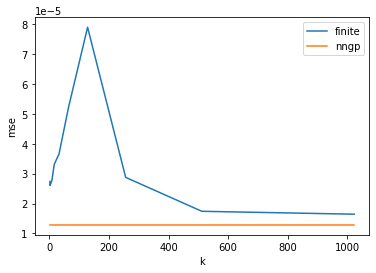

In [ ]:
plt.plot(ks, nn_loss, label='finite')
plt.plot(ks, [nngp_loss] * len(ks), label='nngp')
plt.legend()
plt.xlabel('k')
plt.ylabel('mse')
plt.show()